# Ivanov model

Based on *Ivanov et al. "Stochastic feedback and the regulation of biological rythms" In $Europhysics letters$ 43 (1998) pp. 363-368*

The model of Ivanov is a statistical model that considers that the heart rate is influenced by 3 elements:

- The sinoatrial node (SA)
- The sympathetic systems (SS) which speeds up the heart rate
- The parasympathetic system (PS) which slows the heart rate

In this model, it is considered that the time $\tau (n+1)$ between 2 heart beats $n$ and $n+1$ can be computed in the following way:

$$\tau(n+1)-\tau(n) = I_{SA}(n) + I_{PS}(n, \tau_{PS}(n)) + \sum_{j=1}^N I^j_{SS}(n, \tau^j_{SS}(n))$$

where: 

- 
$$
I_k(n) = \left\{
    \begin{array}{ll}
        w_k(1+\eta) & \mbox{if } \tau(n) < \tau_k \\
        - w_k(1+\eta) & \mbox{Otherwise}
    \end{array}
\right.
$$

- $\tau_k$ is the preferred level for $\tau(n)$. It remains the same value for a certain amount of time $T$
- $w_k$ is the stength of the input feedback biasing the walker to return to its preferred level $\tau_k$
- $\eta$ is white noise



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from numpy import random
from scipy.stats import uniform
from MFDFA import MFDFA
from tqdm import tqdm

from scipy.stats import norm
from scipy.optimize import minimize

import sys
sys.path.append('../')
import FractalModels as fm
import FractalAnalysis as fa

## Initialising the parameters

The value used in the article will be the one used to build the model, i.e.

- $N = 7$
- $w_{SA} = w_{SS} = w_{PS}/3 = 0.01s$
- $\eta$ is symmetrical exponential distribution (Laplace) with 0 mean and 0.5 scale
- $\tau_{SA} = 0.6$
- $\tau_{PS}$ follows a uniform distribution between $[0.9,1.5]$
- $\tau_{SS}^j$ follows a uniform distribution between $[0.2,1.0]$
- $T$ follows a normal distribution with a mean of 1000 beats

$\tau(0)$ will be initialized at $\tau_{SA}$

In [2]:
N = 7    

w_SA = 0.01
w_SS = 0.01
w_PS = 0.03

t_SA = 0.6

# Lower and upper bound for tau_PS and tau_SS
t_SS_lower = 0.2
t_SS_higher = 1
t_PS_lower = 0.9
t_PS_higher = 1.5

# Exponential distribution for eta
mean_eta = 0
std_eta = 0.5*math.sqrt(2)
# Normal distribution for the time T_lock
mean_T = 1000
std_T = 500

# Number of beats considered for the generated signal
Num_beats = 20000

In [15]:
# Intialising all variable

t_n = t_SA #tau(n)
signal0 = np.zeros(Num_beats) #final signal

# Time T_lock
T_PS = random.normal(mean_T, std_T)
T_SS = np.zeros(N)
for i in range(N):
    T_SS[i] = random.normal(mean_T, std_T)
    

# Preferred levels
t_PS = random.uniform(t_PS_lower, t_PS_higher)

t_SS = np.zeros(N)
for i in range(N):
    t_SS[i] = random.uniform(t_SS_lower, t_SS_higher)
    
    
#Used to keep track of whether the prefered level needs to be updated
cnt_PS = 0 
cnt_SS = np.zeros(N)

In [16]:
#Used to plot the evolution of the preferred levels

t_SA_2 = np.zeros(Num_beats)
t_PS_2 = np.zeros(Num_beats)
t_SS_2 = np.zeros([N, Num_beats])

## Building the model

In [17]:
for n in range(Num_beats):
    diff = 0 # second term of the formula
    
    # SA node
    eta = random.laplace(mean_eta, std_eta/math.sqrt(2))
    if t_n < t_SA:
        diff += w_SA*(1+eta)
    else:
        diff -= w_SA*(1+eta)
    t_SA_2[n] = t_SA
        
    # PS
    eta = random.laplace(mean_eta, std_eta/math.sqrt(2))
    
    # Changing the preferred level
    if cnt_PS > T_PS:
        cnt_PS = 0
        T_PS = random.normal(mean_T, std_T)
        t_PS = random.uniform(t_PS_lower, t_PS_higher)
    t_PS_2[n] = t_PS
    cnt_PS += 1
    
    if t_n < t_PS:
        diff += w_PS*(1+eta)
    else:
        diff -= w_PS*(1+eta)
        

    # SS
    for j in range(N):
        eta = random.laplace(mean_eta, std_eta/math.sqrt(2))
        t_SS_2[j][n] = t_SS[j]
        
        # Changing the preferred level
        if cnt_SS[j] > T_SS[j]:
            t_SS[j] = random.uniform(t_SS_lower, t_SS_higher)
            cnt_SS[j] = 0
            T_SS[j] = random.normal(mean_T, std_T)
            
        cnt_SS[j] += 1
        
        if t_n < t_SS[j]:
            diff += w_SS*(1+eta)
        else:
            diff -= w_SS*(1+eta)

            
    signal0[n] = t_n
    t_n += diff # Value of tau(n+1)        

## Plots
### Signal at different scales

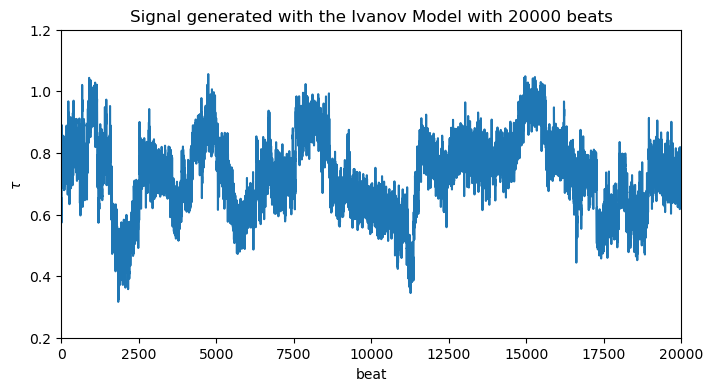

In [19]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(4)

plt.plot(signal0, label="Generated signal")

plt.xlabel("beat")
plt.ylabel(r"$\tau$")
plt.title("Signal generated with the Ivanov Model with " + str(Num_beats) + " beats")
plt.ylim(0.2,1.2)
plt.xlim(0, 20000)
plt.show()

#plt.plot(np.cumsum(signal0[0:1000] - np.mean(signal0[0:1000])))
plt.show()

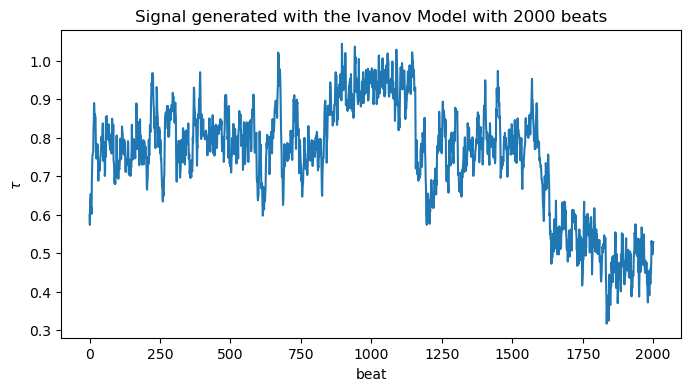

In [20]:
num_beats = 2000
start = 0
end = 2000


f = plt.figure()
f.set_figwidth(8)
f.set_figheight(4)
x = np.linspace(start, end, num_beats)

plt.plot(x, signal0[start:end], label="Generated signal")

plt.xlabel("beat")
plt.ylabel(r"$\tau$")
plt.title("Signal generated with the Ivanov Model with " + str(num_beats) + " beats")
plt.show()

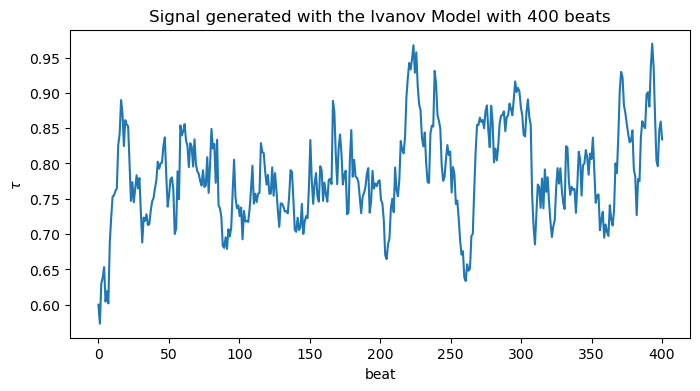

In [21]:
num_beats = 400
start = 0
end = 400


f = plt.figure()
f.set_figwidth(8)
f.set_figheight(4)
x = np.linspace(start, end, num_beats)

plt.plot(x, signal0[start:end], label="Generated signal")

plt.xlabel("beat")
plt.ylabel(r"$\tau$")
plt.title("Signal generated with the Ivanov Model with " + str(num_beats) + " beats")
plt.show()

### Signal with the preferred levels

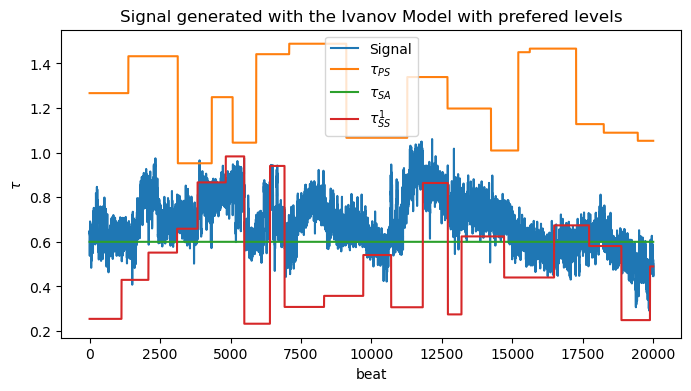

In [29]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(4)

plt.plot(signal0, label="Signal")
plt.plot(t_PS_2, label=r"$\tau_{PS}$")
plt.plot(t_SA_2, label=r"$\tau_{SA}$")
plt.plot(t_SS_2[0], label=r"$\tau_{SS}^1$")

plt.xlabel("beat")
plt.ylabel(r"$\tau$")
plt.title("Signal generated with the Ivanov Model with prefered levels")
plt.legend()
plt.show()

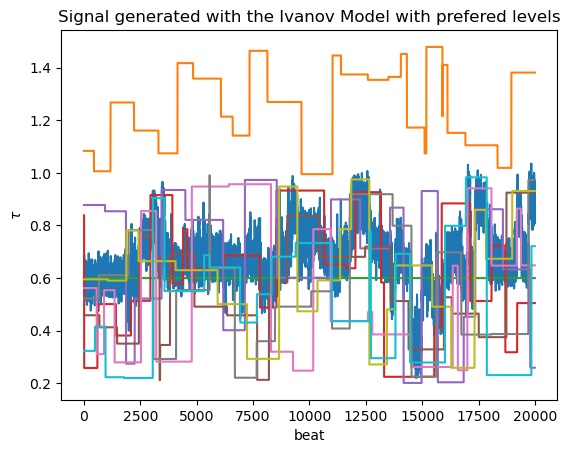

In [26]:
plt.plot(signal0, label="Signal")
plt.plot(t_PS_2, label=r"$\tau_{PS}$")
plt.plot(t_SA_2, label=r"$\tau_{SA}$")
for i in range(N):
    name = r"$\tau_{SS}$"+ str(i+1)
    plt.plot(t_SS_2[i], label=name)
    
plt.xlabel("beat")
plt.ylabel(r"$\tau$")
plt.title("Signal generated with the Ivanov Model with prefered levels")
#plt.legend()
plt.show()

# Power spectrum and DFA analysis

Let's now check that the model is consistent and indeed presents a fractal pattern. The DFA and power spectrum analysis will be performed.

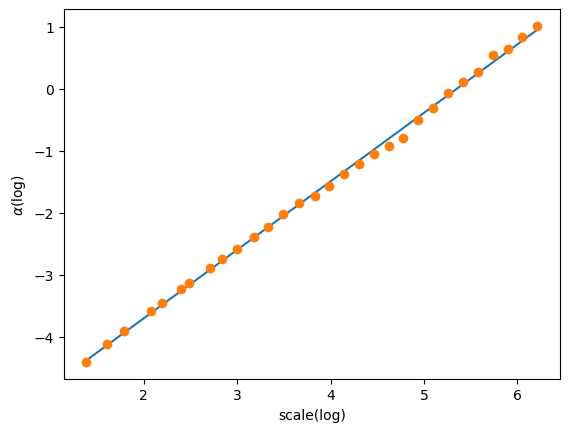

Estimated alpha:  1.1035305922040441


In [40]:
x = np.linspace(np.log(5), np.log(500), 30)
lag = np.exp(x).astype(int)
alpha2 = fa.DFA2(signal0, lag, plot=True, order=1)

print("Estimated alpha: ", alpha2)

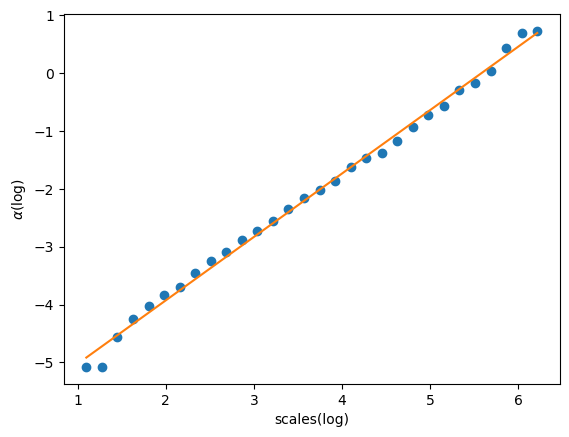

Estimated alpha:  1.096807562101176


In [28]:
alpha = fa.DFA_fast(signal0, limit_start=3, limit_end = 500, plot=True)
print("Estimated alpha: ", alpha)

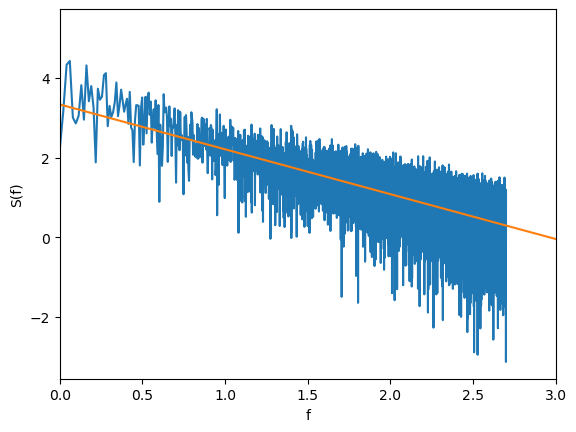

1.1261058710492589

In [15]:
fa.PowerSpectrumAnalysis(signal0, plot=True)

## Assessing the model

However, one signal isn't enough as the results obtained above could be just by a luck, the model depending a lot on the randomness of various valriables. Thus, 1000 signals will be generated and the DFA ans power spectrum analysis will be performed on all these signals.

In [211]:
num_trials = 1000
alphas = np.zeros(num_trials)
alphas2 = np.zeros(num_trials)
betas = np.zeros(num_trials)

x = np.linspace(np.log(5), np.log(500), 30)
lag = np.exp(x).astype(int)
q = 2
order = 1

for i in tqdm(range(num_trials), desc="Loading..."):
    sig = fm.IvanovModel(w_SS=0.015, w_SA=0, w_PS=0, N=10)
    #alphas[i] = fa.DFA_fast(sig, limit_end=500, limit_start=5) # Very slow
    alphas2[i] = fa.DFA2(sig, lag)
    betas[i] = fa.PowerSpectrumAnalysis(sig)
    


Loading...: 100%|██████████| 1000/1000 [12:26<00:00,  1.34it/s]


In [212]:
print("Alpha mean: ", np.mean(alphas))
print("Alpha2 mean: ", np.mean(alphas2))
print("Beta mean: ", np.mean(betas))

Alpha mean:  0.0
Alpha2 mean:  1.0731429062195386
Beta mean:  0.9058291474835569


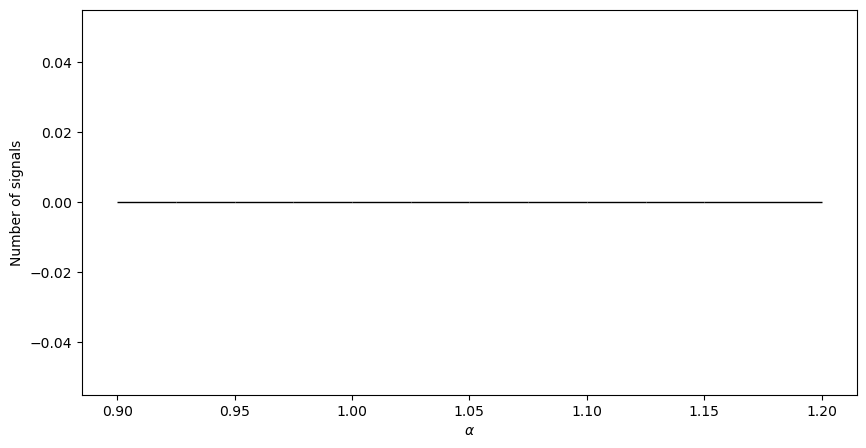

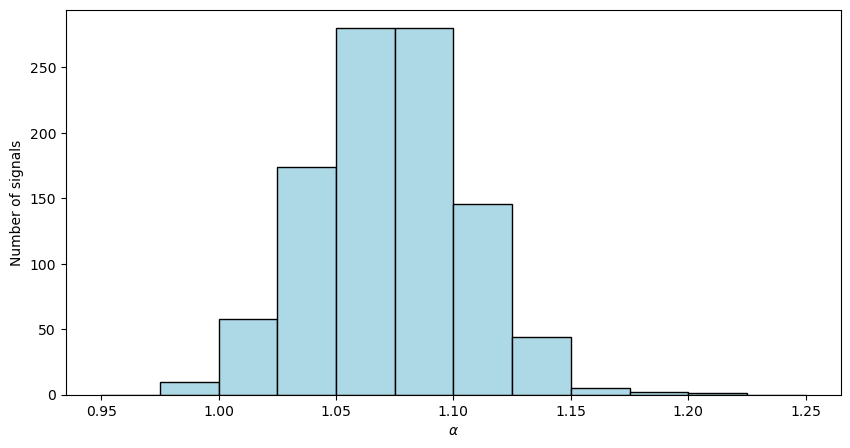

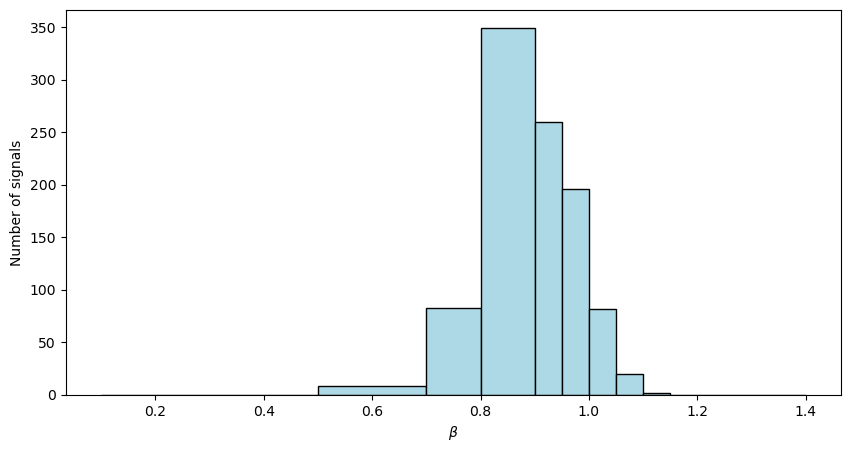

In [220]:
fig, axis = plt.subplots(figsize = (10, 5))
axis.hist(alphas, bins = [ 0.9, 0.925, 0.95, 0.975, 1, 1.025, 1.05, 1.075, 1.1, 1.125, 1.15, 1.2], color="lightblue", ec="black")
plt.xlabel(r"$\alpha$")
plt.ylabel("Number of signals")
plt.show()

fig, axis = plt.subplots(figsize = (10, 5))
#axis.hist(alphas2, bins = [ 0.9, 0.925, 0.95, 0.975, 1, 1.025, 1.05, 1.075, 1.1, 1.125, 1.15, 1.2], color="lightblue", ec="black")
axis.hist(alphas2, bins = [0.95, 0.975, 1, 1.025, 1.05, 1.075, 1.1, 1.125, 1.15, 1.175, 1.2, 1.225, 1.25], color="lightblue", ec="black")
plt.xlabel(r"$\alpha$")
plt.ylabel("Number of signals")
plt.show()

fig, axis = plt.subplots(figsize = (10, 5))
axis.hist(betas, bins = [0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 1,1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.4], color="lightblue", ec="black")
plt.xlabel(r"$\beta$")
plt.ylabel("Number of signals")
plt.show()

## Effect of the various parameters
This section analyses the effect of one parameter of the Ivanov model on the generated signal.

In [3]:
def PrintGoodValues(alphas, parameters, confidence, expected_val):
    """
    Prints the intervals of parameter values in which the signals generated with
    these parameters value keep the fractal pattern (measured with the alpha
    coefficient of DFA)

    Arguments:
    - alphas: the mean of alpha values computed for each parameter value
    - parameters: the corresponding parameter values
    - confidence: the precision accepted for the fractal pattern
    - expected_value: the expected value for alpha. The alpha value thus must be
                        between [expected_value - confidence, expected_value 
                                                                + confidence]
    """

    final_print = "Intervals with the correct values: "
    start = -1
    
    lower_bound = expected_val - confidence
    upper_bound = expected_val + confidence
    
    for i in range(len(alphas)):
        a = alphas[i]
        # alpha[i] is in the correct interval
        if a > lower_bound and a < upper_bound:
            # alpha[i-1] wasn't in the correct interval
            if start==-1:
                start = parameters[i]
                if i == len(alphas)-1:
                    final_print += str(start) + " "
            # alpha[i] is the last element of alpahs
            elif i == len(alphas)-1:
                final_print += "[" + str(start) + "," + str(parameters[i]) + "] "
            
        # alpha[i] isn't in the correct interval
        else:
            # alpha[i-1] was in the correct interval
            if start != -1 and i!=0:
                end = parameters[i-1]
                if end == start:
                    final_print += str(start) + " "
                else:
                    final_print += "[" + str(start) + "," + str(parameters[i-1]) + "] "
            start = -1
                    
    print(final_print)


def PlotParameters(x, alphas2, means, stds, xlab):
    """
    Plot the evolution of the fractal pattern (alpha of DFA) of signals generated
    with the Ivanov model based on one parameter value. It also prints the evolution
    of the mean and the standard deviation of that signal.

    Arguments:
    - x: the parameters value considered
    - alphas2: the corresponding alpha coefficient values
    - means: the corresponding mean values
    - stds: the corresponding standard deviation
    - xlab: the xlabel of the plots
    """
    fig, ax = plt.subplots()
    ax.axhspan(0.95, 1.05, facecolor='green', alpha=0.5)
    ax.axhspan(1.05, 1.15, facecolor='lightblue', alpha=0.5)
    ax.axhspan(0.85, 0.95, facecolor='lightblue', alpha=0.5)

    plt.plot(x,alphas2)
    plt.xlabel(xlab)
    plt.ylabel(r"$\alpha$")
    plt.show()
    
    plt.plot(x,means)
    plt.xlabel(xlab)
    plt.ylabel(r"mean of the signal(s)")
    plt.show()
    
    plt.plot(x,stds)
    plt.xlabel(xlab)
    plt.ylabel(r"standard deviation")
    plt.show()    

100%|██████████| 50/50 [06:23<00:00,  7.66s/it]


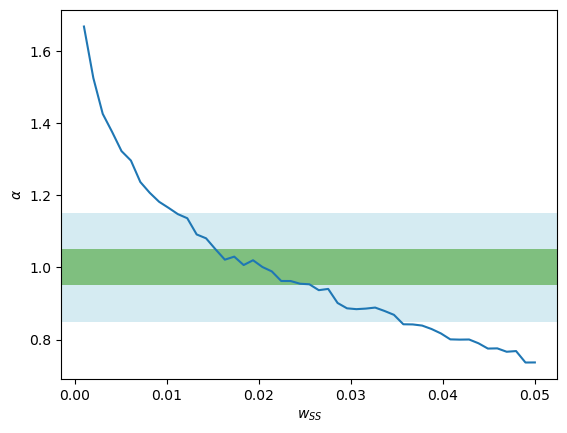

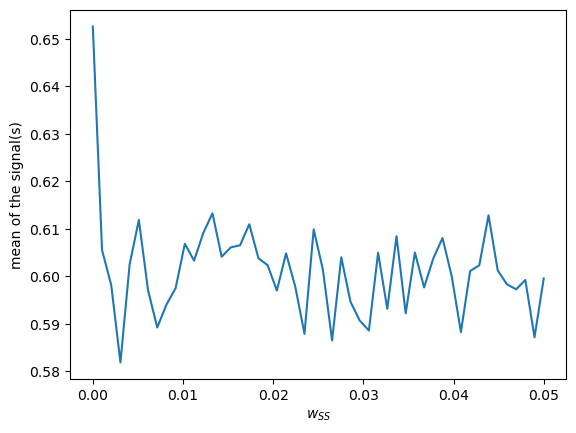

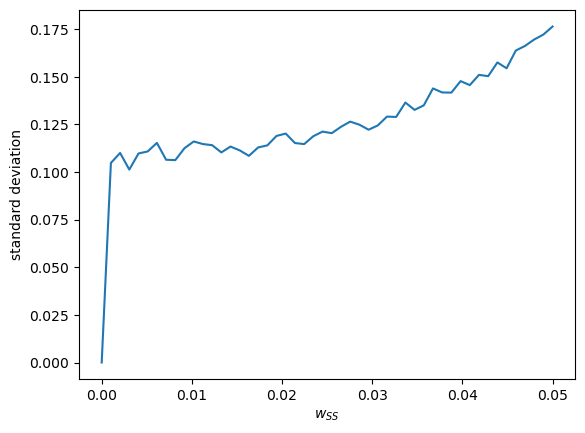

In [178]:
"""
- 0: Number of sympathic signals
- 1: w_SA
- 2: w_SS
- 3: w_PS
- 4: preferred level of SA
- 5: lower bound of the preferred level of SS
- 6: higher bound of the preferred level of SS
- 7: lower bound of the preferred level of PS
- 8: higher bound of the preferred level of PS
- 9: mean of the time T
- 10: standard deviation of the time T
- 11: standard deviation of the white noise eta
- 12: scale of the white noise eta
"""

x = np.linspace(np.log(5), np.log(500), 30)
lag = np.exp(x).astype(int)

param = 2   # Parameter to analyse
num_trials = 10     # Number of values computed for a same parameter value
num_points = 50     # Number of different parameter values to be considered
limits = [[0, num_points],  # Bounds of the values considered for each parameter
          [0, 0.1], 
          [0, 0.05], 
          [0, 0.1], 
          [0.2, 3], 
          [0.2, 0.6], 
          [0.2, 1.5], 
          [0.6, 1.5],
          [0.9, 3],
          [1, 20000],
          [1, 1000],
          [0, 1],
          [0, math.sqrt(2)]]

titles =["N",                           # xlabel of the plots for each parameter
         r"$w_{SA}$",
         r"$w_{SS}$",
         r"$w_{PS}$",
         r"$\tau_{SA}$",
         r"Upper bound of $\tau_{SS}$",
         r"Lower bound of $\tau_{SS}$",
         r"Upper bound of $\tau_{PS}$",
         r"Lower bound of $\tau_{PS}$",
         "Mean of T",
         "Standard deviation of T",
         r"Standard deviation of $\eta$",
         r"Scale of  $\eta$"]

alphas2 = []    # alpha parameter for each parameter value
means = []      # Means of the signal for each parameter value
stds = []       # Standard deviations of the signal for each parameter
x = np.linspace(limits[param][0], limits[param][1], num_points)

for el in tqdm(x):
    tmp_alphas = np.zeros(num_trials)
    tmp_means = np.zeros(num_trials)
    tmp_std = np.zeros(num_trials)
    for i in range(num_trials):
        if param == 0:
            sig = fm.IvanovModel(N=int(el), std_eta=0.5*math.sqrt(2))
        elif param == 1:
            sig = fm.IvanovModel(w_SA=el, std_eta=0.5*math.sqrt(2))
        elif param == 2:
            sig = fm.IvanovModel(w_SS=el, std_eta=0.5*math.sqrt(2), w_PS=0, w_SA=0, N=10)
        elif param == 3:
            sig = fm.IvanovModel(w_PS=el, std_eta=0.5*math.sqrt(2))
        elif param == 4:
            sig = fm.IvanovModel(t_SA=el, std_eta=0.5*math.sqrt(2))
        elif param == 5:
            sig = fm.IvanovModel(t_SS_lower=el, std_eta=0.5*math.sqrt(2))
        elif param == 6:
            sig = fm.IvanovModel(t_SS_higher=el, std_eta=0.5*math.sqrt(2))
        elif param == 7:
            sig = fm.IvanovModel(t_PS_lower=el, std_eta=0.5*math.sqrt(2))
        elif param == 8:
            sig = fm.IvanovModel(t_PS_higher=el, std_eta=0.5*math.sqrt(2))
        elif param == 9:
            sig = fm.IvanovModel(mean_T=el, std_eta=0.5*math.sqrt(2))
        elif param == 10:
            sig = fm.IvanovModel(std_T=el, std_eta=0.5*math.sqrt(2))
        elif param == 11 or param == 12:
            sig = fm.IvanovModel(std_eta=el)
        else:
            sig = fm.IvanovModel(std_eta=0.5*math.sqrt(2))

        tmp_alphas[i] = fa.DFA2(sig, lag)
        tmp_means[i] = np.mean(sig)
        tmp_std[i] = np.std(sig)

    alphas2.append(np.mean(tmp_alphas))
    means.append(np.mean(tmp_means))
    stds.append(np.mean(tmp_std))

if param == 12:
    x = x/math.sqrt(2)

PlotParameters(x, alphas2, means, stds, titles[param])

In [7]:
confidence = 0.1
expected_val = 1
PrintGoodValues(alphas2, x, confidence, expected_val)

Intervals with the correct values: [0.4489795918367347,0.9183673469387755] 


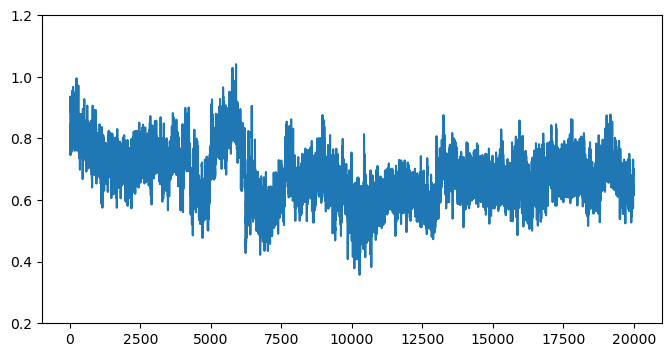

In [142]:
sig = fm.IvanovModel(N=10, std_eta=0.5*math.sqrt(2))
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(4)
plt.plot(sig)
plt.ylim(0.2, 1.2)
plt.show()